In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
id2label = {0: "entailment", 1: "neutral", 2: "contradiction"}
label2id = {"entailment": 0, "neutral": 1, "contradiction": 2}

MNLI = pd.read_csv('./glue_data/MNLI/train.tsv', sep='\t', on_bad_lines='skip')

mlni_keep_columns = ['sentence1', 'sentence2', 'gold_label']
cleaned_mnli = MNLI[mlni_keep_columns].dropna()
cleaned_mnli.columns = ['premise', 'hypothesis', 'label']

cleaned_mnli['label'] = cleaned_mnli['label'].apply(lambda x: label2id[x])

cleaned_mnli.head()

,premise,hypothesis,label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0
3,How do you know? All this is their information...,This information belongs to them.,0
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1


In [3]:
from IPython.display import display

raw_data      = pd.read_csv('../data/sentence-relations/train.csv', index_col='id')
raw_submissions = pd.read_csv('../data/sentence-relations/test.csv', index_col='id')

# Drop chinese and thai
raw_data = raw_data[raw_data['lang_abv'] != 'zh']
raw_data = raw_data[raw_data['lang_abv'] != 'th']

raw_data = raw_data.drop(columns=['lang_abv', 'language'])
raw_data.index = range(len(raw_data))

additional_data = pd.read_csv('./glue_data/RTE/train.tsv', sep='\t')
additional_data = additional_data.drop(columns=['index'])
additional_data.columns = ['premise', 'hypothesis', 'label']
additional_data['label'] = additional_data['label'].apply(lambda x: 0 if x == 'entailment' else 2)

# Keep old test data
training_data, test_data = train_test_split(raw_data, test_size=0.2, random_state=42)

# Add additional data into training data
training_data = pd.concat([training_data, additional_data, cleaned_mnli], ignore_index=True)
training_data = training_data.drop_duplicates()
training_data = training_data.reset_index(drop=True)

print("Amount of training data:", len(training_data))

print("Amount of test data:", len(test_data))

display(training_data.head())
display(test_data.head())

Amount of training data: 402656
Amount of test data: 2268


,premise,hypothesis,label
0,The experiment lasted only until Ahkenaten's d...,The experiment ended with Ahkenaten's death.,0
1,"200.000 alfaz ki novel $25 kai hisab se 8,000 ...",ایک 200000 الفاظ والے ناول جو 25 ڈالر کا ہو اس...,2
2,Σας ευχαριστούμε που υποστηρίξατε το Μουσείο Τ...,Είμαστε πολύ χαρούμενοι που βοηθήσατε να στηρί...,0
3,Two more weeks with my cute TV satellite dish...,My appreciation of my satellite dish has incre...,0
4,"They are built on the site of David's Tower, o...",The structures are on the site of David's Tower.,0


,premise,hypothesis,label
1396,well UNLV they say UNLV may be the greatest am...,UNLV may be the greatest amateur baseball team...,1
543,"For example, the first number in Column (10) s...",Mail sent between households make up 6.6 perce...,0
2631,The following are examples of how agencies eng...,"Agencies can engage employee unions, for example:",0
8183,Yadi zilizojaa za historia zimetapakaa na uhar...,Ushahidi uko kwenye uharibifu katika yadi ya u...,0
5843,C-R ilişkisi aslında bir lokasyondan diğerine ...,C-R ilişkileri bölgeden bölgeye değişir.,0


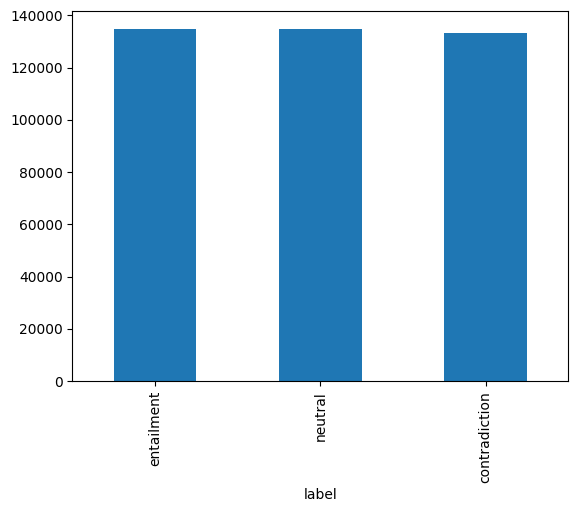

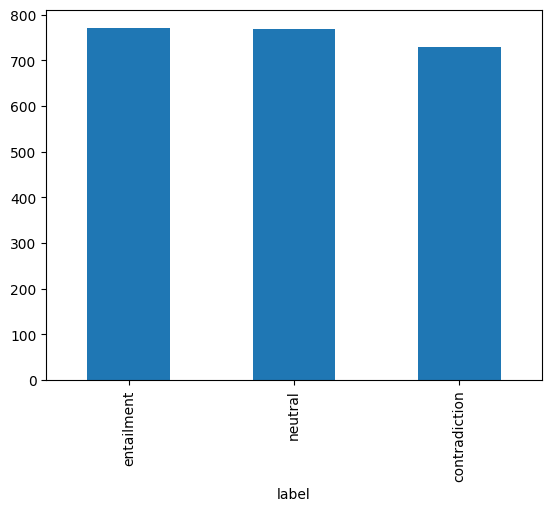

In [4]:
# Plot label distribution
training_data['label'].value_counts().plot(kind='bar')
plt.xticks([0, 1, 2], ['entailment', 'neutral', 'contradiction'])
plt.show()
test_data['label'].value_counts().plot(kind='bar')
plt.xticks([0, 1, 2], ['entailment', 'neutral', 'contradiction'])
plt.show()

In [5]:
counter = 0
total = len(test_data)

training_premises = training_data['premise'].values

testing_premises = test_data['premise'].values

drop_indices = []

for i, premise in enumerate(testing_premises):

    if counter % 100 == 0:
        print(f"Progress: {counter}/{total}")

    counter += 1

    if premise in training_premises:
        training_index = training_data[training_data['premise'] == premise].index
        training_data = training_data.drop(training_index)

training_data = training_data.reset_index(drop=True)

Progress: 0/2268
Progress: 100/2268
Progress: 200/2268
Progress: 300/2268
Progress: 400/2268
Progress: 500/2268
Progress: 600/2268
Progress: 700/2268
Progress: 800/2268
Progress: 900/2268
Progress: 1000/2268
Progress: 1100/2268
Progress: 1200/2268
Progress: 1300/2268
Progress: 1400/2268
Progress: 1500/2268
Progress: 1600/2268
Progress: 1700/2268
Progress: 1800/2268
Progress: 1900/2268
Progress: 2000/2268
Progress: 2100/2268
Progress: 2200/2268


In [6]:
print("Amount of training data after removing duplicates:", len(training_data))

Amount of training data after removing duplicates: 401024


In [7]:
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer

roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base", truncation=True)
data_collator = DataCollatorWithPadding(tokenizer=roberta_tokenizer)

/home/alex/Documents/Studium/2-Master/ki-lab-ss23/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alex/Documents/Studium/2-Master/ki-lab-ss23/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
from torch.utils.data import Dataset, DataLoader

class BertSentenceDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

        self.X = self.data['premise'] + '[SEP]' + self.data['hypothesis']
        self.y = self.data['label']

        self.encoded = self.tokenizer(self.X.tolist(), padding=True, truncation=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encoded['input_ids'][idx],
            'attention_mask': self.encoded['attention_mask'][idx],
            'label': self.y.iloc[idx]
        }

# Take half of the training data
training_data = training_data.sample(frac=0.2, random_state=42)

bert_train_dataset = BertSentenceDataset(training_data, roberta_tokenizer)
bert_test_dataset = BertSentenceDataset(test_data, roberta_tokenizer)

In [9]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
num_labels = len(id2label)

model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=num_labels, id2label=id2label, label2id=label2id)

/home/alex/Documents/Studium/2-Master/ki-lab-ss23/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

training_args = TrainingArguments(
    output_dir="roberta-base-sentence-relation",
    learning_rate=1e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=4,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [11]:
print(f"Running on device: {training_args.device}")

Running on device: cuda:0


In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=bert_train_dataset,
    eval_dataset=bert_test_dataset,
    tokenizer=roberta_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

  8%|▊         | 3128/40104 [29:29<5:48:38,  1.77it/s]
                                                      
  1%|          | 500/80208 [04:28<11:54:00,  1.86it/s]

{'loss': 0.3159, 'grad_norm': 0.34364500641822815, 'learning_rate': 9.937662078595653e-06, 'epoch': 0.02}


                                                       
  1%|          | 1000/80208 [08:53<10:53:32,  2.02it/s]

{'loss': 0.2964, 'grad_norm': 0.04653819650411606, 'learning_rate': 9.875324157191304e-06, 'epoch': 0.05}


                                                       
  2%|▏         | 1500/80208 [12:59<10:40:52,  2.05it/s]

{'loss': 0.2994, 'grad_norm': 27.920795440673828, 'learning_rate': 9.812986235786955e-06, 'epoch': 0.07}


                                                       
  2%|▏         | 2000/80208 [17:05<10:42:41,  2.03it/s]

{'loss': 0.2904, 'grad_norm': 0.04502629116177559, 'learning_rate': 9.750648314382606e-06, 'epoch': 0.1}


                                                       
  3%|▎         | 2500/80208 [21:10<10:32:26,  2.05it/s]

{'loss': 0.2379, 'grad_norm': 0.026918848976492882, 'learning_rate': 9.688310392978257e-06, 'epoch': 0.12}


                                                       
  4%|▎         | 3000/80208 [25:15<10:29:48,  2.04it/s]

{'loss': 0.2214, 'grad_norm': 0.036208800971508026, 'learning_rate': 9.625972471573908e-06, 'epoch': 0.15}


                                                       
  4%|▍         | 3500/80208 [29:20<10:25:13,  2.04it/s]

{'loss': 0.4138, 'grad_norm': 0.12165851891040802, 'learning_rate': 9.56363455016956e-06, 'epoch': 0.17}


                                                       
  5%|▍         | 4000/80208 [33:25<10:20:34,  2.05it/s]

{'loss': 0.5139, 'grad_norm': 23.822885513305664, 'learning_rate': 9.50129662876521e-06, 'epoch': 0.2}


                                                       
  6%|▌         | 4500/80208 [37:30<10:21:45,  2.03it/s]

{'loss': 0.504, 'grad_norm': 180.6373748779297, 'learning_rate': 9.438958707360862e-06, 'epoch': 0.22}


                                                       
  6%|▌         | 5000/80208 [41:35<10:14:02,  2.04it/s]

{'loss': 0.4869, 'grad_norm': 0.11432383209466934, 'learning_rate': 9.376620785956514e-06, 'epoch': 0.25}


                                                       
  7%|▋         | 5500/80208 [45:40<10:12:04,  2.03it/s]

{'loss': 0.5361, 'grad_norm': 149.35321044921875, 'learning_rate': 9.314282864552166e-06, 'epoch': 0.27}


                                                       
  7%|▋         | 6000/80208 [49:46<10:09:11,  2.03it/s]

{'loss': 0.5296, 'grad_norm': 0.4774087369441986, 'learning_rate': 9.251944943147816e-06, 'epoch': 0.3}


                                                       
  8%|▊         | 6500/80208 [53:51<10:00:28,  2.05it/s]

{'loss': 0.503, 'grad_norm': 454.05487060546875, 'learning_rate': 9.189607021743468e-06, 'epoch': 0.32}


                                                       
  9%|▊         | 7000/80208 [58:00<10:01:33,  2.03it/s]

{'loss': 0.4767, 'grad_norm': 0.08011985570192337, 'learning_rate': 9.12726910033912e-06, 'epoch': 0.35}


                                                         
  9%|▉         | 7500/80208 [1:02:05<9:54:50,  2.04it/s]

{'loss': 0.4933, 'grad_norm': 41.52312088012695, 'learning_rate': 9.06493117893477e-06, 'epoch': 0.37}


                                                        
 10%|▉         | 8000/80208 [1:06:10<9:50:21,  2.04it/s]

{'loss': 0.5235, 'grad_norm': 101.4981689453125, 'learning_rate': 9.002593257530422e-06, 'epoch': 0.4}


                                                        
 11%|█         | 8500/80208 [1:10:15<9:47:56,  2.03it/s]

{'loss': 0.4467, 'grad_norm': 0.08941026777029037, 'learning_rate': 8.940255336126072e-06, 'epoch': 0.42}


                                                        
 11%|█         | 9000/80208 [1:14:20<9:42:01,  2.04it/s]

{'loss': 0.5186, 'grad_norm': 641.560791015625, 'learning_rate': 8.877917414721724e-06, 'epoch': 0.45}


                                                        
 12%|█▏        | 9500/80208 [1:18:26<9:39:51,  2.03it/s]

{'loss': 0.5162, 'grad_norm': 0.16644546389579773, 'learning_rate': 8.815579493317376e-06, 'epoch': 0.47}


                                                         
 12%|█▏        | 10000/80208 [1:22:31<9:36:10,  2.03it/s]

{'loss': 0.4724, 'grad_norm': 0.1258610337972641, 'learning_rate': 8.753241571913027e-06, 'epoch': 0.5}


                                                         
 13%|█▎        | 10500/80208 [1:26:37<9:30:15,  2.04it/s]

{'loss': 0.5134, 'grad_norm': 1.542248010635376, 'learning_rate': 8.69090365050868e-06, 'epoch': 0.52}


                                                         
 14%|█▎        | 11000/80208 [1:30:43<9:25:29,  2.04it/s]

{'loss': 0.564, 'grad_norm': 0.1759490966796875, 'learning_rate': 8.62856572910433e-06, 'epoch': 0.55}


                                                         
 14%|█▍        | 11500/80208 [1:34:48<9:21:39,  2.04it/s]

{'loss': 0.5395, 'grad_norm': 0.06991972774267197, 'learning_rate': 8.566227807699981e-06, 'epoch': 0.57}


                                                         
 15%|█▍        | 12000/80208 [1:38:52<9:14:12,  2.05it/s]

{'loss': 0.4734, 'grad_norm': 21.728363037109375, 'learning_rate': 8.503889886295631e-06, 'epoch': 0.6}


                                                         
 16%|█▌        | 12500/80208 [1:43:01<9:22:30,  2.01it/s]

{'loss': 0.5242, 'grad_norm': 0.2082514464855194, 'learning_rate': 8.441551964891283e-06, 'epoch': 0.62}


                                                          
 16%|█▌        | 13000/80208 [1:47:14<9:20:23,  2.00it/s]

{'loss': 0.4863, 'grad_norm': 0.314429372549057, 'learning_rate': 8.379214043486935e-06, 'epoch': 0.65}


                                                         
 17%|█▋        | 13500/80208 [1:51:25<9:14:39,  2.00it/s]

{'loss': 0.5882, 'grad_norm': 0.15930594503879547, 'learning_rate': 8.316876122082585e-06, 'epoch': 0.67}


                                                         
 17%|█▋        | 14000/80208 [1:55:33<9:11:07,  2.00it/s]

{'loss': 0.6051, 'grad_norm': 2.5875725746154785, 'learning_rate': 8.254538200678237e-06, 'epoch': 0.7}


                                                         
 18%|█▊        | 14500/80208 [1:59:42<9:06:28,  2.00it/s]

{'loss': 0.5404, 'grad_norm': 0.1461072564125061, 'learning_rate': 8.192200279273889e-06, 'epoch': 0.72}


                                                         
 19%|█▊        | 15000/80208 [2:03:50<8:59:29,  2.01it/s]

{'loss': 0.5857, 'grad_norm': 0.6261795163154602, 'learning_rate': 8.12986235786954e-06, 'epoch': 0.75}


                                                         
 19%|█▉        | 15500/80208 [2:08:00<8:57:16,  2.01it/s]

{'loss': 0.6038, 'grad_norm': 0.36172598600387573, 'learning_rate': 8.067524436465191e-06, 'epoch': 0.77}


                                                         
 20%|█▉        | 16000/80208 [2:12:10<8:54:10,  2.00it/s]

{'loss': 0.5825, 'grad_norm': 81.34098052978516, 'learning_rate': 8.005186515060843e-06, 'epoch': 0.8}


                                                         
 21%|██        | 16500/80208 [2:16:20<8:48:24,  2.01it/s]

{'loss': 0.6082, 'grad_norm': 34.79169845581055, 'learning_rate': 7.942848593656493e-06, 'epoch': 0.82}


                                                         
 21%|██        | 17000/80208 [2:20:30<8:44:06,  2.01it/s]

{'loss': 0.6778, 'grad_norm': 0.25607651472091675, 'learning_rate': 7.880510672252145e-06, 'epoch': 0.85}


                                                         
 22%|██▏       | 17500/80208 [2:24:40<8:44:27,  1.99it/s]

{'loss': 0.6522, 'grad_norm': 0.07504953444004059, 'learning_rate': 7.818172750847797e-06, 'epoch': 0.87}


                                                         
 22%|██▏       | 18000/80208 [2:28:49<8:38:58,  2.00it/s]

{'loss': 0.6751, 'grad_norm': 28.847267150878906, 'learning_rate': 7.755834829443447e-06, 'epoch': 0.9}


                                                         
 23%|██▎       | 18500/80208 [2:33:00<8:34:48,  2.00it/s]

{'loss': 0.6893, 'grad_norm': 86.06743621826172, 'learning_rate': 7.693496908039099e-06, 'epoch': 0.92}


                                                         
 24%|██▎       | 19000/80208 [2:37:10<8:29:13,  2.00it/s]

{'loss': 0.657, 'grad_norm': 85.151123046875, 'learning_rate': 7.63115898663475e-06, 'epoch': 0.95}


                                                         
 24%|██▍       | 19500/80208 [2:41:20<8:25:57,  2.00it/s]

{'loss': 0.6595, 'grad_norm': 40.34888458251953, 'learning_rate': 7.568821065230401e-06, 'epoch': 0.97}


                                                         
 25%|██▍       | 20000/80208 [2:45:30<8:20:39,  2.00it/s]

{'loss': 0.6894, 'grad_norm': 151.69908142089844, 'learning_rate': 7.506483143826053e-06, 'epoch': 1.0}


 25%|██▌       | 20052/80208 [2:45:55<6:38:33,  2.52it/s]





















































































































































































































































































































































































































































































































































































                                                         
                                                     

 25%|██▌       | 20052/80208 [2:47:20<6:38:33,  2.52it/s]



{'eval_loss': 0.8814085721969604, 'eval_accuracy': 0.673721340388007, 'eval_f1': 0.6759772306459887, 'eval_precision': 0.6967122829883287, 'eval_recall': 0.6737103277858729, 'eval_runtime': 84.9157, 'eval_samples_per_second': 26.709, 'eval_steps_per_second': 6.677, 'epoch': 1.0}


                                                           
 26%|██▌       | 20500/80208 [2:51:06<8:16:59,  2.00it/s]

{'loss': 0.5229, 'grad_norm': 352.8221435546875, 'learning_rate': 7.444145222421703e-06, 'epoch': 1.02}


                                                         
 26%|██▌       | 21000/80208 [2:55:15<8:11:40,  2.01it/s]

{'loss': 0.5218, 'grad_norm': 0.946161150932312, 'learning_rate': 7.381807301017355e-06, 'epoch': 1.05}


                                                         
 27%|██▋       | 21500/80208 [2:59:24<8:06:55,  2.01it/s]

{'loss': 0.5449, 'grad_norm': 0.3961726725101471, 'learning_rate': 7.319469379613007e-06, 'epoch': 1.07}


                                                         
 27%|██▋       | 22000/80208 [3:03:33<8:03:05,  2.01it/s]

{'loss': 0.5181, 'grad_norm': 0.6151817440986633, 'learning_rate': 7.257131458208658e-06, 'epoch': 1.1}


                                                         
 28%|██▊       | 22500/80208 [3:07:42<7:57:03,  2.02it/s]

{'loss': 0.4694, 'grad_norm': 196.1182403564453, 'learning_rate': 7.19479353680431e-06, 'epoch': 1.12}


                                                         
 29%|██▊       | 23000/80208 [3:11:51<7:53:38,  2.01it/s]

{'loss': 0.5174, 'grad_norm': 0.15289221704006195, 'learning_rate': 7.13245561539996e-06, 'epoch': 1.15}


                                                         
 29%|██▉       | 23500/80208 [3:16:00<7:51:37,  2.00it/s]

{'loss': 0.5506, 'grad_norm': 0.07060260325670242, 'learning_rate': 7.070117693995612e-06, 'epoch': 1.17}


                                                         
 30%|██▉       | 24000/80208 [3:20:09<7:46:13,  2.01it/s]

{'loss': 0.5378, 'grad_norm': 175.49717712402344, 'learning_rate': 7.007779772591264e-06, 'epoch': 1.2}


                                                         
 31%|███       | 24500/80208 [3:24:17<7:44:08,  2.00it/s]

{'loss': 0.4944, 'grad_norm': 50.35895538330078, 'learning_rate': 6.945441851186915e-06, 'epoch': 1.22}


                                                         
 31%|███       | 25000/80208 [3:28:26<7:39:15,  2.00it/s]

{'loss': 0.5712, 'grad_norm': 118.59757232666016, 'learning_rate': 6.8831039297825665e-06, 'epoch': 1.25}


                                                         
 32%|███▏      | 25500/80208 [3:32:35<7:34:36,  2.01it/s]

{'loss': 0.5454, 'grad_norm': 0.07702187448740005, 'learning_rate': 6.820766008378217e-06, 'epoch': 1.27}


                                                         
 32%|███▏      | 26000/80208 [3:36:44<7:29:17,  2.01it/s]

{'loss': 0.5033, 'grad_norm': 0.1269271969795227, 'learning_rate': 6.7584280869738685e-06, 'epoch': 1.3}


                                                         
 33%|███▎      | 26500/80208 [3:40:53<7:25:20,  2.01it/s]

{'loss': 0.5157, 'grad_norm': 0.11026797443628311, 'learning_rate': 6.6960901655695195e-06, 'epoch': 1.32}


                                                         
 34%|███▎      | 27000/80208 [3:45:02<7:17:20,  2.03it/s]

{'loss': 0.5015, 'grad_norm': 45.750770568847656, 'learning_rate': 6.633752244165171e-06, 'epoch': 1.35}


                                                         
 34%|███▍      | 27500/80208 [3:49:09<7:14:54,  2.02it/s]

{'loss': 0.5097, 'grad_norm': 1.1154476404190063, 'learning_rate': 6.571414322760823e-06, 'epoch': 1.37}


                                                         
 35%|███▍      | 28000/80208 [3:53:17<7:11:17,  2.02it/s]

{'loss': 0.5589, 'grad_norm': 59.03923797607422, 'learning_rate': 6.509076401356473e-06, 'epoch': 1.4}


                                                         
 36%|███▌      | 28500/80208 [3:57:26<7:07:31,  2.02it/s]

{'loss': 0.5193, 'grad_norm': 0.4660472571849823, 'learning_rate': 6.446738479952125e-06, 'epoch': 1.42}


                                                         
 36%|███▌      | 29000/80208 [4:01:33<7:02:17,  2.02it/s]

{'loss': 0.5579, 'grad_norm': 11.719783782958984, 'learning_rate': 6.384400558547776e-06, 'epoch': 1.45}


                                                         
 37%|███▋      | 29500/80208 [4:05:42<6:58:17,  2.02it/s]

{'loss': 0.5553, 'grad_norm': 286.58465576171875, 'learning_rate': 6.322062637143428e-06, 'epoch': 1.47}


                                                         
 37%|███▋      | 30000/80208 [4:09:50<6:56:35,  2.01it/s]

{'loss': 0.5534, 'grad_norm': 158.02398681640625, 'learning_rate': 6.259724715739078e-06, 'epoch': 1.5}


                                                         
 38%|███▊      | 30500/80208 [4:13:58<6:51:54,  2.01it/s]

{'loss': 0.5273, 'grad_norm': 0.13979460299015045, 'learning_rate': 6.19738679433473e-06, 'epoch': 1.52}


                                                         
 39%|███▊      | 31000/80208 [4:18:06<6:45:07,  2.02it/s]

{'loss': 0.6001, 'grad_norm': 231.9788360595703, 'learning_rate': 6.135048872930382e-06, 'epoch': 1.55}


                                                         
 39%|███▉      | 31500/80208 [4:22:13<6:42:26,  2.02it/s]

{'loss': 0.5335, 'grad_norm': 0.16241496801376343, 'learning_rate': 6.072710951526033e-06, 'epoch': 1.57}


                                                         
 40%|███▉      | 32000/80208 [4:26:22<6:39:01,  2.01it/s]

{'loss': 0.5279, 'grad_norm': 0.4261745810508728, 'learning_rate': 6.010373030121685e-06, 'epoch': 1.6}


                                                         
 41%|████      | 32500/80208 [4:30:30<6:33:45,  2.02it/s]

{'loss': 0.5365, 'grad_norm': 129.19590759277344, 'learning_rate': 5.948035108717335e-06, 'epoch': 1.62}


                                                         
 41%|████      | 33000/80208 [4:34:39<6:31:27,  2.01it/s]

{'loss': 0.5411, 'grad_norm': 145.34536743164062, 'learning_rate': 5.885697187312987e-06, 'epoch': 1.65}


                                                         
 42%|████▏     | 33500/80208 [4:38:47<6:24:53,  2.02it/s]

{'loss': 0.5917, 'grad_norm': 16.246185302734375, 'learning_rate': 5.823359265908638e-06, 'epoch': 1.67}


                                                         
 42%|████▏     | 34000/80208 [4:42:55<6:24:32,  2.00it/s]

{'loss': 0.5306, 'grad_norm': 13.541790962219238, 'learning_rate': 5.7610213445042894e-06, 'epoch': 1.7}


                                                         
 43%|████▎     | 34500/80208 [4:47:04<6:17:59,  2.02it/s]

{'loss': 0.587, 'grad_norm': 406.2778015136719, 'learning_rate': 5.698683423099941e-06, 'epoch': 1.72}


                                                         
 44%|████▎     | 35000/80208 [4:51:11<6:12:43,  2.02it/s]

{'loss': 0.5979, 'grad_norm': 113.93895721435547, 'learning_rate': 5.6363455016955914e-06, 'epoch': 1.75}


                                                         
 44%|████▍     | 35500/80208 [4:55:18<6:08:23,  2.02it/s]

{'loss': 0.5388, 'grad_norm': 0.02176014706492424, 'learning_rate': 5.574007580291243e-06, 'epoch': 1.77}


                                                         
 45%|████▍     | 36000/80208 [4:59:26<6:03:38,  2.03it/s]

{'loss': 0.5389, 'grad_norm': 0.10185933858156204, 'learning_rate': 5.511669658886894e-06, 'epoch': 1.8}


                                                         
 46%|████▌     | 36500/80208 [5:03:33<6:01:13,  2.02it/s]

{'loss': 0.5271, 'grad_norm': 102.08641052246094, 'learning_rate': 5.449331737482546e-06, 'epoch': 1.82}


                                                         
 46%|████▌     | 37000/80208 [5:07:41<5:55:43,  2.02it/s]

{'loss': 0.5714, 'grad_norm': 88.59651947021484, 'learning_rate': 5.386993816078198e-06, 'epoch': 1.85}


                                                         
 47%|████▋     | 37500/80208 [5:11:48<5:52:15,  2.02it/s]

{'loss': 0.4751, 'grad_norm': 0.5865496397018433, 'learning_rate': 5.324655894673848e-06, 'epoch': 1.87}


                                                         
 47%|████▋     | 38000/80208 [5:15:55<5:46:32,  2.03it/s]

{'loss': 0.5656, 'grad_norm': 12.89233684539795, 'learning_rate': 5.2623179732695e-06, 'epoch': 1.9}


                                                         
 48%|████▊     | 38500/80208 [5:20:02<5:43:52,  2.02it/s]

{'loss': 0.5594, 'grad_norm': 84.86785125732422, 'learning_rate': 5.199980051865151e-06, 'epoch': 1.92}


                                                         
 49%|████▊     | 39000/80208 [5:24:08<5:38:43,  2.03it/s]

{'loss': 0.4937, 'grad_norm': 0.06251146644353867, 'learning_rate': 5.137642130460803e-06, 'epoch': 1.94}


                                                         
 49%|████▉     | 39500/80208 [5:28:15<5:35:24,  2.02it/s]

{'loss': 0.5316, 'grad_norm': 45.9588623046875, 'learning_rate': 5.075304209056454e-06, 'epoch': 1.97}


                                                         
 50%|████▉     | 40000/80208 [5:32:22<5:30:00,  2.03it/s]

{'loss': 0.5015, 'grad_norm': 506.308837890625, 'learning_rate': 5.012966287652105e-06, 'epoch': 1.99}


 50%|█████     | 40104/80208 [5:33:13<4:22:23,  2.55it/s]





















































































































































































































































































































































































































































































































































































                                                         
                                                     

 50%|█████     | 40104/80208 [5:34:36<4:22:23,  2.55it/s]



{'eval_loss': 1.2321100234985352, 'eval_accuracy': 0.6768077601410935, 'eval_f1': 0.6760376238617735, 'eval_precision': 0.6767806636820078, 'eval_recall': 0.6766379007808788, 'eval_runtime': 83.8323, 'eval_samples_per_second': 27.054, 'eval_steps_per_second': 6.764, 'epoch': 2.0}


                                                           
 50%|█████     | 40500/80208 [5:37:53<5:26:17,  2.03it/s]

{'loss': 0.4081, 'grad_norm': 0.05411677435040474, 'learning_rate': 4.950628366247756e-06, 'epoch': 2.02}


                                                         
 51%|█████     | 41000/80208 [5:41:59<5:22:23,  2.03it/s]

{'loss': 0.4191, 'grad_norm': 0.03816867619752884, 'learning_rate': 4.8882904448434076e-06, 'epoch': 2.04}


                                                         
 52%|█████▏    | 41500/80208 [5:46:05<5:19:13,  2.02it/s]

{'loss': 0.3277, 'grad_norm': 1.121073603630066, 'learning_rate': 4.8259525234390586e-06, 'epoch': 2.07}


                                                         
 52%|█████▏    | 42000/80208 [5:50:12<5:15:04,  2.02it/s]

{'loss': 0.443, 'grad_norm': 7.7454681396484375, 'learning_rate': 4.76361460203471e-06, 'epoch': 2.09}


                                                         
 53%|█████▎    | 42500/80208 [5:54:18<5:09:47,  2.03it/s]

{'loss': 0.4035, 'grad_norm': 0.03422930836677551, 'learning_rate': 4.701276680630361e-06, 'epoch': 2.12}


                                                         
 54%|█████▎    | 43000/80208 [5:58:25<5:06:01,  2.03it/s]

{'loss': 0.4006, 'grad_norm': 191.6285858154297, 'learning_rate': 4.638938759226012e-06, 'epoch': 2.14}


                                                         
 54%|█████▍    | 43500/80208 [6:02:32<5:00:59,  2.03it/s]

{'loss': 0.4005, 'grad_norm': 0.12727132439613342, 'learning_rate': 4.576600837821664e-06, 'epoch': 2.17}


                                                         
 55%|█████▍    | 44000/80208 [6:06:38<4:57:29,  2.03it/s]

{'loss': 0.4109, 'grad_norm': 0.19832298159599304, 'learning_rate': 4.514262916417315e-06, 'epoch': 2.19}


                                                         
 55%|█████▌    | 44500/80208 [6:10:44<4:52:44,  2.03it/s]

{'loss': 0.3643, 'grad_norm': 14.093745231628418, 'learning_rate': 4.451924995012967e-06, 'epoch': 2.22}


                                                         
 56%|█████▌    | 45000/80208 [6:14:51<4:50:04,  2.02it/s]

{'loss': 0.3691, 'grad_norm': 0.030722027644515038, 'learning_rate': 4.389587073608618e-06, 'epoch': 2.24}


                                                         
 57%|█████▋    | 45500/80208 [6:18:57<4:44:07,  2.04it/s]

{'loss': 0.3807, 'grad_norm': 0.038492411375045776, 'learning_rate': 4.327249152204269e-06, 'epoch': 2.27}


                                                         
 57%|█████▋    | 46000/80208 [6:23:03<4:40:02,  2.04it/s]

{'loss': 0.3889, 'grad_norm': 0.08242742717266083, 'learning_rate': 4.264911230799921e-06, 'epoch': 2.29}


                                                         
 58%|█████▊    | 46500/80208 [6:27:09<4:36:19,  2.03it/s]

{'loss': 0.3663, 'grad_norm': 0.10277237743139267, 'learning_rate': 4.202573309395572e-06, 'epoch': 2.32}


                                                         
 59%|█████▊    | 47000/80208 [6:31:15<4:32:48,  2.03it/s]

{'loss': 0.3832, 'grad_norm': 0.020096978172659874, 'learning_rate': 4.140235387991223e-06, 'epoch': 2.34}


                                                         
 59%|█████▉    | 47500/80208 [6:35:21<4:27:03,  2.04it/s]

{'loss': 0.4014, 'grad_norm': 0.03779667243361473, 'learning_rate': 4.077897466586874e-06, 'epoch': 2.37}


                                                         
 60%|█████▉    | 48000/80208 [6:39:27<4:24:00,  2.03it/s]

{'loss': 0.3896, 'grad_norm': 0.0887305736541748, 'learning_rate': 4.015559545182526e-06, 'epoch': 2.39}


                                                         
 60%|██████    | 48500/80208 [6:43:33<4:20:21,  2.03it/s]

{'loss': 0.3891, 'grad_norm': 0.04982240870594978, 'learning_rate': 3.9532216237781775e-06, 'epoch': 2.42}


                                                         
 61%|██████    | 49000/80208 [6:47:39<4:15:29,  2.04it/s]

{'loss': 0.3748, 'grad_norm': 0.04129635915160179, 'learning_rate': 3.8908837023738285e-06, 'epoch': 2.44}


                                                         
 62%|██████▏   | 49500/80208 [6:51:45<4:12:07,  2.03it/s]

{'loss': 0.3814, 'grad_norm': 1.1991010904312134, 'learning_rate': 3.8285457809694795e-06, 'epoch': 2.47}


                                                         
 62%|██████▏   | 50000/80208 [6:55:51<4:08:01,  2.03it/s]

{'loss': 0.3684, 'grad_norm': 0.057220302522182465, 'learning_rate': 3.766207859565131e-06, 'epoch': 2.49}


                                                         
 63%|██████▎   | 50500/80208 [6:59:57<4:02:47,  2.04it/s]

{'loss': 0.3935, 'grad_norm': 324.1784973144531, 'learning_rate': 3.7038699381607823e-06, 'epoch': 2.52}


                                                         
 64%|██████▎   | 51000/80208 [7:04:02<3:58:39,  2.04it/s]

{'loss': 0.4396, 'grad_norm': 0.12122564762830734, 'learning_rate': 3.6415320167564333e-06, 'epoch': 2.54}


                                                         
 64%|██████▍   | 51500/80208 [7:08:09<3:54:53,  2.04it/s]

{'loss': 0.3445, 'grad_norm': 0.027835886925458908, 'learning_rate': 3.5791940953520847e-06, 'epoch': 2.57}


                                                         
 65%|██████▍   | 52000/80208 [7:12:15<3:51:32,  2.03it/s]

{'loss': 0.3834, 'grad_norm': 0.045378658920526505, 'learning_rate': 3.5168561739477366e-06, 'epoch': 2.59}


                                                         
 65%|██████▌   | 52500/80208 [7:16:21<3:47:31,  2.03it/s]

{'loss': 0.4105, 'grad_norm': 124.21701049804688, 'learning_rate': 3.454518252543387e-06, 'epoch': 2.62}


                                                         
 66%|██████▌   | 53000/80208 [7:20:27<3:42:39,  2.04it/s]

{'loss': 0.3812, 'grad_norm': 10.761848449707031, 'learning_rate': 3.392180331139039e-06, 'epoch': 2.64}


                                                         
 67%|██████▋   | 53500/80208 [7:24:33<3:38:38,  2.04it/s]

{'loss': 0.3865, 'grad_norm': 0.09379790723323822, 'learning_rate': 3.32984240973469e-06, 'epoch': 2.67}


                                                         
 67%|██████▋   | 54000/80208 [7:28:38<3:33:47,  2.04it/s]

{'loss': 0.3749, 'grad_norm': 2.974245071411133, 'learning_rate': 3.2675044883303414e-06, 'epoch': 2.69}


                                                         
 68%|██████▊   | 54500/80208 [7:32:44<3:30:26,  2.04it/s]

{'loss': 0.3824, 'grad_norm': 465.06427001953125, 'learning_rate': 3.205166566925993e-06, 'epoch': 2.72}


                                                         
 69%|██████▊   | 55000/80208 [7:36:50<3:26:27,  2.03it/s]

{'loss': 0.4078, 'grad_norm': 0.41944894194602966, 'learning_rate': 3.142828645521644e-06, 'epoch': 2.74}


                                                         
 69%|██████▉   | 55500/80208 [7:40:55<3:22:40,  2.03it/s]

{'loss': 0.3951, 'grad_norm': 0.1913360357284546, 'learning_rate': 3.0804907241172956e-06, 'epoch': 2.77}


                                                         
 70%|██████▉   | 56000/80208 [7:45:01<3:18:41,  2.03it/s]

{'loss': 0.3639, 'grad_norm': 606.7608642578125, 'learning_rate': 3.0181528027129462e-06, 'epoch': 2.79}


                                                         
 70%|███████   | 56500/80208 [7:49:07<3:14:29,  2.03it/s]

{'loss': 0.3656, 'grad_norm': 31.87630271911621, 'learning_rate': 2.955814881308598e-06, 'epoch': 2.82}


                                                         
 71%|███████   | 57000/80208 [7:53:13<3:10:00,  2.04it/s]

{'loss': 0.3684, 'grad_norm': 1.331807017326355, 'learning_rate': 2.893476959904249e-06, 'epoch': 2.84}


                                                         
 72%|███████▏  | 57500/80208 [7:57:19<3:06:00,  2.03it/s]

{'loss': 0.4016, 'grad_norm': 0.6651293039321899, 'learning_rate': 2.8311390384999005e-06, 'epoch': 2.87}


                                                         
 72%|███████▏  | 58000/80208 [8:01:25<3:02:03,  2.03it/s]

{'loss': 0.4037, 'grad_norm': 58.802711486816406, 'learning_rate': 2.768801117095552e-06, 'epoch': 2.89}


                                                         
 73%|███████▎  | 58500/80208 [8:05:30<2:58:28,  2.03it/s]

{'loss': 0.3735, 'grad_norm': 0.06267952919006348, 'learning_rate': 2.706463195691203e-06, 'epoch': 2.92}


                                                         
 74%|███████▎  | 59000/80208 [8:09:37<2:54:18,  2.03it/s]

{'loss': 0.3508, 'grad_norm': 405.9101257324219, 'learning_rate': 2.6441252742868547e-06, 'epoch': 2.94}


                                                         
 74%|███████▍  | 59500/80208 [8:13:43<2:49:48,  2.03it/s]

{'loss': 0.4225, 'grad_norm': 1.437227725982666, 'learning_rate': 2.5817873528825053e-06, 'epoch': 2.97}


                                                         
 75%|███████▍  | 60000/80208 [8:17:50<2:45:52,  2.03it/s]

{'loss': 0.4282, 'grad_norm': 0.22080110013484955, 'learning_rate': 2.519449431478157e-06, 'epoch': 2.99}


 75%|███████▌  | 60156/80208 [8:19:07<2:11:40,  2.54it/s]





















































































































































































































































































































































































































































































































































































                                                         
                                                     

 75%|███████▌  | 60156/80208 [8:20:31<2:11:40,  2.54it/s]



{'eval_loss': 1.4685651063919067, 'eval_accuracy': 0.6834215167548501, 'eval_f1': 0.6836616339748169, 'eval_precision': 0.6856074871665778, 'eval_recall': 0.6840602198790519, 'eval_runtime': 83.9904, 'eval_samples_per_second': 27.003, 'eval_steps_per_second': 6.751, 'epoch': 3.0}


                                                           
 75%|███████▌  | 60500/80208 [8:23:22<2:41:20,  2.04it/s]

{'loss': 0.3005, 'grad_norm': 0.0385017953813076, 'learning_rate': 2.457111510073808e-06, 'epoch': 3.02}


                                                         
 76%|███████▌  | 61000/80208 [8:27:28<2:37:13,  2.04it/s]

{'loss': 0.2544, 'grad_norm': 450.161865234375, 'learning_rate': 2.3947735886694595e-06, 'epoch': 3.04}


                                                         
 77%|███████▋  | 61500/80208 [8:31:34<2:33:02,  2.04it/s]

{'loss': 0.2663, 'grad_norm': 0.13189135491847992, 'learning_rate': 2.332435667265111e-06, 'epoch': 3.07}


                                                         
 77%|███████▋  | 62000/80208 [8:35:39<2:28:53,  2.04it/s]

{'loss': 0.225, 'grad_norm': 0.016254588961601257, 'learning_rate': 2.2700977458607624e-06, 'epoch': 3.09}


                                                         
 78%|███████▊  | 62500/80208 [8:39:45<2:24:26,  2.04it/s]

{'loss': 0.2958, 'grad_norm': 390.52813720703125, 'learning_rate': 2.2077598244564138e-06, 'epoch': 3.12}


                                                         
 79%|███████▊  | 63000/80208 [8:43:51<2:20:01,  2.05it/s]

{'loss': 0.2743, 'grad_norm': 0.024623984470963478, 'learning_rate': 2.1454219030520648e-06, 'epoch': 3.14}


                                                         
 79%|███████▉  | 63500/80208 [8:47:56<2:17:04,  2.03it/s]

{'loss': 0.3165, 'grad_norm': 0.2458224892616272, 'learning_rate': 2.083083981647716e-06, 'epoch': 3.17}


                                                         
 80%|███████▉  | 64000/80208 [8:52:02<2:12:00,  2.05it/s]

{'loss': 0.2871, 'grad_norm': 4.78631067276001, 'learning_rate': 2.020746060243367e-06, 'epoch': 3.19}


                                                         
 80%|████████  | 64500/80208 [8:56:07<2:08:46,  2.03it/s]

{'loss': 0.232, 'grad_norm': 0.007528172340244055, 'learning_rate': 1.9584081388390186e-06, 'epoch': 3.22}


                                                         
 81%|████████  | 65000/80208 [9:00:12<2:03:40,  2.05it/s]

{'loss': 0.2439, 'grad_norm': 0.1773967742919922, 'learning_rate': 1.8960702174346702e-06, 'epoch': 3.24}


                                                         
 82%|████████▏ | 65500/80208 [9:04:18<2:00:54,  2.03it/s]

{'loss': 0.3163, 'grad_norm': 237.1604461669922, 'learning_rate': 1.8337322960303214e-06, 'epoch': 3.27}


                                                         
 82%|████████▏ | 66000/80208 [9:08:24<1:56:38,  2.03it/s]

{'loss': 0.2275, 'grad_norm': 0.017364121973514557, 'learning_rate': 1.7713943746259726e-06, 'epoch': 3.29}


                                                         
 83%|████████▎ | 66500/80208 [9:12:29<1:52:20,  2.03it/s]

{'loss': 0.3005, 'grad_norm': 2.132631778717041, 'learning_rate': 1.7090564532216238e-06, 'epoch': 3.32}


                                                         
 84%|████████▎ | 67000/80208 [9:16:34<1:47:43,  2.04it/s]

{'loss': 0.2691, 'grad_norm': 0.11478190869092941, 'learning_rate': 1.6467185318172752e-06, 'epoch': 3.34}


                                                         
 84%|████████▍ | 67500/80208 [9:20:38<1:43:22,  2.05it/s]

{'loss': 0.3032, 'grad_norm': 0.04642583802342415, 'learning_rate': 1.5843806104129264e-06, 'epoch': 3.37}


                                                         
 85%|████████▍ | 68000/80208 [9:24:42<1:39:56,  2.04it/s]

{'loss': 0.2643, 'grad_norm': 0.034342795610427856, 'learning_rate': 1.5220426890085779e-06, 'epoch': 3.39}


                                                         
 85%|████████▌ | 68500/80208 [9:28:46<1:34:43,  2.06it/s]

{'loss': 0.2611, 'grad_norm': 0.011686344631016254, 'learning_rate': 1.4597047676042293e-06, 'epoch': 3.42}


                                                         
 86%|████████▌ | 69000/80208 [9:32:50<1:30:57,  2.05it/s]

{'loss': 0.2547, 'grad_norm': 0.22545763850212097, 'learning_rate': 1.3973668461998805e-06, 'epoch': 3.44}


                                                         
 87%|████████▋ | 69500/80208 [9:36:54<1:26:28,  2.06it/s]

{'loss': 0.2633, 'grad_norm': 0.006658369675278664, 'learning_rate': 1.3350289247955317e-06, 'epoch': 3.47}


                                                         
 87%|████████▋ | 70000/80208 [9:40:58<1:22:49,  2.05it/s]

{'loss': 0.2644, 'grad_norm': 0.03573702648282051, 'learning_rate': 1.2726910033911829e-06, 'epoch': 3.49}


                                                         
 88%|████████▊ | 70500/80208 [9:45:02<1:18:32,  2.06it/s]

{'loss': 0.3015, 'grad_norm': 0.007363806013017893, 'learning_rate': 1.2103530819868343e-06, 'epoch': 3.52}


                                                         
 89%|████████▊ | 71000/80208 [9:49:06<1:14:26,  2.06it/s]

{'loss': 0.3155, 'grad_norm': 0.03527733311057091, 'learning_rate': 1.1480151605824857e-06, 'epoch': 3.54}


                                                         
 89%|████████▉ | 71500/80208 [9:53:10<1:10:58,  2.04it/s]

{'loss': 0.2916, 'grad_norm': 0.062746562063694, 'learning_rate': 1.085677239178137e-06, 'epoch': 3.57}


                                                         
 90%|████████▉ | 72000/80208 [9:57:14<1:06:41,  2.05it/s]

{'loss': 0.2907, 'grad_norm': 49.89337921142578, 'learning_rate': 1.0233393177737883e-06, 'epoch': 3.59}


                                                          
 90%|█████████ | 72500/80208 [10:01:18<1:02:51,  2.04it/s]

{'loss': 0.2672, 'grad_norm': 0.07636826485395432, 'learning_rate': 9.610013963694395e-07, 'epoch': 3.62}


                                                          
 91%|█████████ | 73000/80208 [10:05:22<58:30,  2.05it/s] 

{'loss': 0.2793, 'grad_norm': 64.89164733886719, 'learning_rate': 8.98663474965091e-07, 'epoch': 3.64}


                                                        
 92%|█████████▏| 73500/80208 [10:09:25<54:40,  2.05it/s] 

{'loss': 0.2701, 'grad_norm': 99.453857421875, 'learning_rate': 8.363255535607422e-07, 'epoch': 3.67}


                                                        
 92%|█████████▏| 74000/80208 [10:13:30<50:40,  2.04it/s] 

{'loss': 0.2596, 'grad_norm': 0.04784933850169182, 'learning_rate': 7.739876321563935e-07, 'epoch': 3.69}


                                                        
 93%|█████████▎| 74500/80208 [10:17:34<46:26,  2.05it/s] 

{'loss': 0.2947, 'grad_norm': 0.05341752991080284, 'learning_rate': 7.116497107520448e-07, 'epoch': 3.72}


                                                        
 94%|█████████▎| 75000/80208 [10:21:38<42:16,  2.05it/s] 

{'loss': 0.2792, 'grad_norm': 12.582474708557129, 'learning_rate': 6.493117893476961e-07, 'epoch': 3.74}


                                                        
 94%|█████████▍| 75500/80208 [10:25:43<38:09,  2.06it/s] 

{'loss': 0.2657, 'grad_norm': 32.62578582763672, 'learning_rate': 5.869738679433473e-07, 'epoch': 3.77}


                                                        
 95%|█████████▍| 76000/80208 [10:29:46<34:13,  2.05it/s] 

{'loss': 0.269, 'grad_norm': 0.051922984421253204, 'learning_rate': 5.246359465389986e-07, 'epoch': 3.79}


                                                        
 95%|█████████▌| 76500/80208 [10:33:50<30:07,  2.05it/s] 

{'loss': 0.2675, 'grad_norm': 0.031137114390730858, 'learning_rate': 4.6229802513464996e-07, 'epoch': 3.82}


                                                        
 96%|█████████▌| 77000/80208 [10:37:54<25:58,  2.06it/s] 

{'loss': 0.2885, 'grad_norm': 52.98662567138672, 'learning_rate': 3.999601037303012e-07, 'epoch': 3.84}


                                                        
 97%|█████████▋| 77500/80208 [10:41:58<22:01,  2.05it/s] 

{'loss': 0.2426, 'grad_norm': 0.12619107961654663, 'learning_rate': 3.376221823259526e-07, 'epoch': 3.86}


                                                        
 97%|█████████▋| 78000/80208 [10:46:02<18:00,  2.04it/s] 

{'loss': 0.2797, 'grad_norm': 0.03615031763911247, 'learning_rate': 2.7528426092160383e-07, 'epoch': 3.89}


                                                        
 98%|█████████▊| 78500/80208 [10:50:07<13:56,  2.04it/s] 

{'loss': 0.1873, 'grad_norm': 0.028202710673213005, 'learning_rate': 2.1294633951725517e-07, 'epoch': 3.91}


                                                        
 98%|█████████▊| 79000/80208 [10:54:12<09:47,  2.06it/s] 

{'loss': 0.2447, 'grad_norm': 0.057014040648937225, 'learning_rate': 1.5060841811290645e-07, 'epoch': 3.94}


                                                        
 99%|█████████▉| 79500/80208 [10:58:16<05:44,  2.06it/s] 

{'loss': 0.2504, 'grad_norm': 0.06017867103219032, 'learning_rate': 8.827049670855776e-08, 'epoch': 3.96}


                                                        
100%|█████████▉| 80000/80208 [11:02:21<01:41,  2.05it/s] 

{'loss': 0.2699, 'grad_norm': 0.01437442097812891, 'learning_rate': 2.593257530420906e-08, 'epoch': 3.99}


100%|██████████| 80208/80208 [11:04:10<00:00,  2.54it/s]





















































































































































































































































































































































































































































































































































































                                                        
                                                      

100%|██████████| 80208/80208 [11:05:34<00:00,  2.54it/s]



{'eval_loss': 1.6927942037582397, 'eval_accuracy': 0.6878306878306878, 'eval_f1': 0.6878986240140043, 'eval_precision': 0.688235036238722, 'eval_recall': 0.6879057069631479, 'eval_runtime': 83.7962, 'eval_samples_per_second': 27.066, 'eval_steps_per_second': 6.766, 'epoch': 4.0}


                                                        
100%|██████████| 80208/80208 [11:05:37<00:00,  2.01it/s] 

{'train_runtime': 39937.4815, 'train_samples_per_second': 8.033, 'train_steps_per_second': 2.008, 'train_loss': 0.4264258215010297, 'epoch': 4.0}


TrainOutput(global_step=80208, training_loss=0.4264258215010297, metrics={'train_runtime': 39937.4815, 'train_samples_per_second': 8.033, 'train_steps_per_second': 2.008, 'total_flos': 8.441204667549696e+16, 'train_loss': 0.4264258215010297, 'epoch': 4.0})

In [13]:
# Get the best model
model = AutoModelForSequenceClassification.from_pretrained('roberta-base-sentence-relation/checkpoint-80208', num_labels=num_labels, id2label=id2label, label2id=label2id)

# Evaluate the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=bert_train_dataset,
    eval_dataset=bert_test_dataset,
    tokenizer=None,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.evaluate()

/home/alex/Documents/Studium/2-Master/ki-lab-ss23/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


OSError: roberta-base-sentence-relation/checkpoint-4816 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`